In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi as π
import firedrake
from firedrake import as_vector, inner, ds
import icepack, icepack.plot, icepack.models

# Damaged ice shelf

In this demo, we'll show how to simulate the evolution of a damaged floating ice shelf by making the enhancement factor dependent on a distributed damage field.
Again, in the spin-up experiment, the objective is to obtain a physically plausible state of some system from an initial guess by simulating its evolution for a long time.

We will again use the same idealized ice shelf geometry from the second tutorial along with the same rough guess for the initial ice thickness, velocity, and assume the shelf is initially undamaged.
First we'll solve the *diagnostic equation* for the velocity througout the ice shelf. We'll then solve the *prognostic equation* to evolve the damage to steady state.

The whole simulation can be divided into three parts:

* Define the shape of the ice shelf and get a triangulation of the interior.
* Define the initial guess for the ice thickness and velocity, and set a value of the rheology and accumulation rate.
* Set the total simulation time and the number of time steps, and then iteratively update the ice thickness, velocity, and damage at each time step.


### Geometry

First we define the geometry of the ice shelf. The inflow boundary will again be a circular arc centered at the origin with a radius of 200 km. The outflow boundary will be another circular arc with a much higher radius.


In [2]:
import pygmsh

R = 200e3
δx = 5e3
geometry = pygmsh.built_in.Geometry()
x1 = geometry.add_point([-R, 0, 0], lcar=δx)
x2 = geometry.add_point([+R, 0, 0], lcar=δx)

center1 = geometry.add_point([0, 0, 0,], lcar=δx)
center2 = geometry.add_point([0, -4 * R, 0], lcar=δx)

arcs = [geometry.add_circle_arc(x1, center1, x2),
        geometry.add_circle_arc(x2, center2, x1)]

In [3]:
line_loop = geometry.add_line_loop(arcs)
plane_surface = geometry.add_plane_surface(line_loop)

physical_lines = [geometry.add_physical(arc) for arc in arcs]
physical_surface = geometry.add_physical(plane_surface)

In [4]:
with open('ice-shelf.geo', 'w') as geo_file:
    geo_file.write(geometry.get_code())

The terminal output from gmsh gives us some diagnostics like how many vertices and triangles it contains. To model advected damage problem, we've created a much higher resolution mesh.

In [5]:
!gmsh ice-shelf.geo -2

Info    : Running 'gmsh ice-shelf.geo -2' [Gmsh 4.3.0, 1 node, max. 1 thread]
Info    : Started on Sun Aug  4 21:58:04 2019
Info    : Reading 'ice-shelf.geo'...
Info    : Done reading 'ice-shelf.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Meshing curve 2 (Circle)
Info    : Done meshing 1D (0.000887 s)
Info    : Meshing 2D...
Info    : Meshing surface 4 (Plane, Delaunay)
Info    : Done meshing 2D (0.217712 s)
Info    : 3793 vertices 7584 elements
Info    : Writing 'ice-shelf.msh'...
Info    : Done writing 'ice-shelf.msh'
Info    : Stopped on Sun Aug  4 21:58:04 2019


In [6]:
mesh = firedrake.Mesh('ice-shelf.msh')

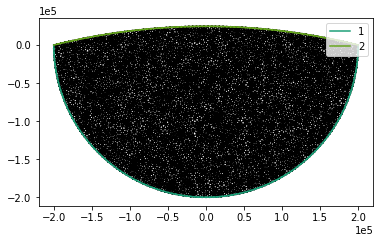

In [7]:
fig, axes = icepack.plot.subplots()
icepack.plot.triplot(mesh)
plt.show(fig)

In the demos for real glaciers that follow, we use all of the same tools.
The main difference is that the boundary arcs are drawn by hand in a geographic information system, rather than defined programatically in Python.
In the repository [glacier-meshes](https://github.com/icepack/glacier-meshes) I've included shapefiles of the outlines of several glaciers and a program to automate the translation of a shapefile into a .geo file using pygmsh.
This will be used in the demo for the Larsen Ice Shelf.

### Input data

To mimic the state of a real ice shelf, we'll pick a few angles along the inflow boundary that represent the centerlines of the ice streams that feed the shelf.
We'll then define velocity and thickness profiles along this inflow boundary.
We don't have a great idea from the outset of what the steady state of the ice shelf is; it doesn't have a simple analytical expression in terms of the coordinates.
Instead, we'll pick a somewhat arbitrary initial profile and evolve it towards steady state.

Many ice shelves (Larsen, Ross, etc.) have several streams feeding them.
Our synthetic glacier will be fed by four streams.
We'll define the inlets by picking the angles around the inflow boundary where each inlet comes in from and the width in radians.
You can re-run this notebook and change the values or the number of streams to whatever you like.

In [8]:
inlet_angles = π * np.array([-3/4, -1/2, -1/3, -1/6])
inlet_widths = π * np.array([1/8, 1/12, 1/24, 1/12])

Next, we'll come up with some rather arbitrary and un-physical input data.
The basic idea is to make the thickness slope down as you go towards the calving terminus and away from the centerline of an inlet.
Likewise the ice speed goes up as you go towards the calving terminus.
In order to make this big nasty algebraic expression, we'll create a list of the perturbation thickness and velocity for each inlet, and combine them all together at the end.

In [9]:
x = firedrake.SpatialCoordinate(mesh)

u_in = 300
h_in = 350
hb = 100
dh, du = 400, 250

hs, us = [], []
for θ, ϕ in zip(inlet_angles, inlet_widths):
    x0 = R * as_vector((np.cos(θ), np.sin(θ)))
    v = -as_vector((np.cos(θ), np.sin(θ)))
    L = inner(x - x0, v)
    W = x - x0 - L * v
    Rn = 2 * ϕ / π * R
    q = firedrake.max_value(1 - (W / Rn)**2, 0)
    hs.append(hb + q * ((h_in - hb) - dh * L /R))
    us.append(firedrake.exp(-4 * (W/R)**2) * (u_in + du * L / R) * v)

To combine the expressions for the thickness and velocity of each inlet into expressions for the whole ice shelf, we'll take the maximum thickness at any point, and the sum of the velocities.

In [10]:
h_expr = firedrake.Constant(hb)
for h in hs:
    h_expr = firedrake.max_value(h, h_expr)
    
u_expr = sum(us)

These are merely algebraic expressions.
To start modeling we need to interpolate these expressions to some function spaces defined over the mesh just as we did in the first ice shelf example.

In [11]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)
V = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2)
D= firedrake.interpolate(firedrake.Constant(0.0), Q)
h0 = firedrake.interpolate(h_expr, Q)
u0 = firedrake.interpolate(u_expr, V)

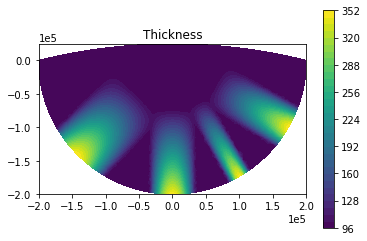

In [12]:
fig, axes = icepack.plot.subplots()
axes.set_title('Thickness')
contours = icepack.plot.tricontourf(h0, 40, axes=axes)
fig.colorbar(contours)

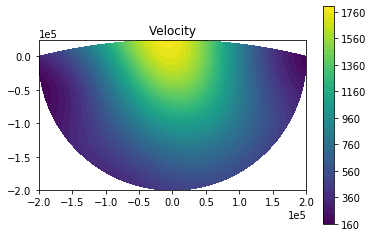

In [13]:
fig, axes = icepack.plot.subplots()
axes.set_title('Velocity')
contours = icepack.plot.tricontourf(u0, 40, axes=axes)
fig.colorbar(contours)

As the simulation progresses, the ice streams, as represented by areas with higher thickness, will spread and grow.

### Modeling
Damage affects the horizontal velocities of an ice shelf via the effective fluidity of the ice column. As ice becomes more damaged, the strength of the bulk material becomes compromised and spreads more quickly. Following the work of Levermann et al. (2012) we define the damaged-rate factor to be:

$A_D = A_0(\frac{1}{(1-D)})^n$

where $D$ is the distributed damage field with values between 0 (undamaged) and 1 (completely damaged). To evolve the damage field in our prognostic model we call the damage_tranport solver, which  advects, sources and sinks damage to evolve the bulk fluidity of the ice towards steady state.

In [14]:
Temp = 260
ε = 0.001
A = firedrake.interpolate(firedrake.Constant(icepack.rate_factor(Temp)), Q)
n=icepack.constants.glen_flow_law
def damaged_fluidity(u, h, A0):
    eps=(1/(1-(1-ε)*D))**n
    A = A0 * eps
    return icepack.models.viscosity.viscosity_depth_averaged(u, h, A)


In [15]:
ice_shelf = icepack.models.IceShelf(viscosity=damaged_fluidity)
help(ice_shelf.diagnostic_solve)

Help on method diagnostic_solve in module icepack.models.ice_shelf:

diagnostic_solve(u0, h, dirichlet_ids, tol=1e-06, **kwargs) method of icepack.models.ice_shelf.IceShelf instance
    Solve for the ice velocity from the thickness
    
    Parameters
    ----------
    u0 : firedrake.Function
        Initial guess for the ice velocity; the Dirichlet boundaries
        are taken from `u0`
    h : firedrake.Function
        Ice thickness
    dirichlet_ids : list of int
        list of integer IDs denoting the parts of the boundary where
        Dirichlet conditions should be applied
    tol : float
        dimensionless tolerance for when to terminate Newton's method
    
    Returns
    -------
    u : firedrake.Function
        Ice velocity
    
    Other parameters
    ----------------
    **kwargs
        All other keyword arguments will be passed on to the
        `viscosity` and `gravity` functions that were set when this
        model object was initialized



For now we'll use a fluidity that assumes a spatially constant temperature of -18${}^\circ$C.
The code itself assumes that all temperatures are in Kelvin.
In later demos, we'll use a spatially variable fluidity coefficient and show how to infer it from observations.

Finally, we need to prescribe the boundary conditions for the velocity and the convergence tolerance for the nonlinear solver.
Since the boundary conditions and convergence tolerance are usually the same throughout a simulation, we'll pack them into a dictionary call `opts` and reuse it throughout.

To compute the velocity field, we call the diagnostic solve method of the ice shelf object.
This function takes in the initial guess `u0` for the velocity, the thickness, the fluidity, and all the extra options we packed into `opts`.

In [16]:
opts = {'dirichlet_ids': [1], 'tol': 1e-12}
h = h0.copy(deepcopy=True)
u = ice_shelf.diagnostic_solve(u0=u0, h=h,A0=A,D=D, **opts)

Here we passed all the arguments to `diagnostic_solve` as keywords.
This convention will be used throughout all the demos.
Passing arguments by keyword is slightly more verbose than passing them by position, but it saves you the trouble of remembering what order everything goes in.
On top of that, many fields are *only* passed in as keyword arguments.
For example, the fluidity parameter is not a positional argument of the diagnostic solve routine.
The reason for this choice, as we'll see later, is that it's much easier to swap out components of the model physics for your own customized versions.

The following plot shows streamlines of the velocity field.
These kind of plots are useful for showing areas of convergence and divergence of the flow field.

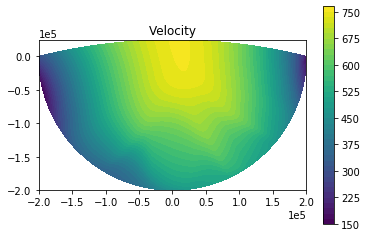

In [17]:
fig, axes = icepack.plot.subplots()
axes.set_title('Velocity')
ud=u
contours = icepack.plot.tricontourf(u, 40, axes=axes)
fig.colorbar(contours)

To project the state of the ice shelf forward in time, we'll use the prognostic solve method.
The prognostic solver updates the ice thickness forward by a given timestep given the accumulation rate and velocity.
We then update the velocity using the diagnostic solver at each timestep, and use the updated velocities to advect, source and sink distributed damage. The following code runs the model forward for several years until the ice shelf is roughly in steady state.

In [18]:
T = 250
num_timesteps = 250
dt = T / num_timesteps
a = firedrake.Constant(0.0)
D_inflow=firedrake.Constant(0.0,Q)

for step in range(num_timesteps + 1):
    h = ice_shelf.prognostic_solve(dt, h0=h, a=a, u=u, h_inflow=h0)
    D = ice_shelf.damage_transport.solve(dt,D0=D,u=u,A=A,D_max=1.0,D_inflow=D_inflow)
    u = ice_shelf.diagnostic_solve(u0=u, h=h,A0=A,D=D, **opts)    
    print('.' if step % 25 == 0 else '', end='', flush=True)

...........

The main loop to run the simulation consists of alternating calls to the prognostic and diagnostic solve methods of the model object with a new feedback between velocity and damage that also affects the steady state thickness. We can visualize the damage field and plot the difference between the steady state velocity with and without damage evolution.

In [19]:
step

250

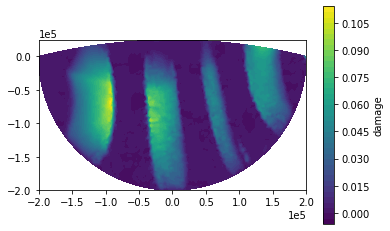

In [20]:
fig, axes = icepack.plot.subplots()
contours = icepack.plot.tricontourf(D, 40, axes=axes)
fig.colorbar(contours, label='damage')
plt.show(fig)

A stream plot of the ice velocity shows that the areas of greatest flow divergence have moved around relative to the initial velocity.

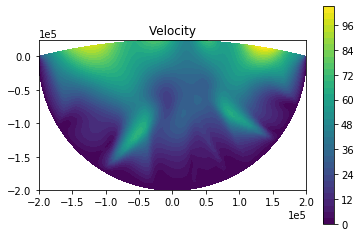

In [29]:
up=firedrake.interpolate(ud-u,V)
fig, axes = icepack.plot.subplots()
axes.set_title('Velocity')
contours = icepack.plot.tricontourf(up, 40, axes=axes)
fig.colorbar(contours)

A useful quantity to know is how much ice is moving through the system.
In the previous demo, we showed how to symbolically create functionals of the solution.
We can use this to calculate the total ice flux through the calving terminus.

In [22]:
ν = firedrake.FacetNormal(mesh)
flux = h * inner(u, ν) * ds(2)

The extra argument to `ds` indicates that we want to integrate over just the calving terminus rather than over the entire domain boundary.
The variable `flux` is a symbolic representation of this quantity in terms of the input fields; it isn't a number but rather a description of how to compute a number.
The function `firedrake.assemble` does the actual work of evaluating the integral.

In [23]:
print('Flux: {} km^3 / year'.format(firedrake.assemble(flux) / 1e9))

Flux: 37.86465225670245 km^3 / year


To check the degree to which the system really is in steady state, we can compute the flux along the inflow boundary rather than along the terminus.
This should be equal to the flux out of the domain since we've set the accumulation rate to be zero.

In [24]:
influx = -h * inner(u, ν) * ds(1)
print('Influx: {} km^3 / year'.format(firedrake.assemble(influx) / 1e9))

Influx: 38.156905358858886 km^3 / year


The influx and outflux are reasonably close, with the influx slightly exceeding the outflux.
The ice shelf will thicken, increasing the flux out of the terminus, until the two values equilibrate.
If you want to experiment with this example a bit more, you can increase the final time $T$ and then compare the fluxes.

### Conclusion

In the last demo, we saw how to create a mesh, define a finite element space, interpolate functions to that finite element space, and analyze the results through either plotting or more general post-processing.
Here we've shown how to use these functions as an input to an ice shelf flow model.
There are a lot of interesting experiments you can do with synthetic ice shelves.
For example, you can approximate the effect of seasonality by making the accumulation rate and inflow thickness a sinusoidal function of time.
You can then add things like tidal effects and see how they alter the overall ice flow.
In the next demo, we'll show how to use these functions for simulating a real ice shelf using observational data.